In [1]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt 

import random

import platform_opt
from players import *

In [2]:
# SIMULATION PARAMETERS
T = 8                 # max number of timesteps
pi = {1: 0.43294, 
     -1: 0.56706}          # number of members in groups a and b #estimated from probability_sharing_distributions.ipynb
pi_a = pi[1]

M = 100000              # size of unit mass


# probability of like | click, user group, article group
# P indexed (article group, user group). 
#estimated from probability_sharing_distributions.ipynb
P = {( 1,  1):  0.0692, 
     ( -1, 1):  0.001815,
     (1,  -1):  0.003995,
     (-1, -1):  0.08344} 

beta_dist = {(1,1) : (41.45784070052453, 556.8653671739492),
            (-1,1) : (0.7519296311195025, 413.4664888783973),
            (1,-1) : (6.096475779403813, 1519.8459882514462),
            (-1,-1): (2152.960173995409, 23647.671142918956)}

# utility for liking, known to both user and platform,
# v indexed by (article shown, user group) pair
#unclear what these values should be!
v = {( 1,  1):   2000.,
     (-1,  1):   100.,
     ( 1, -1):   100.,
     (-1, -1):   2000. }

# cost of clicking, known to both user and platform,
# c indexed by (article shown, user group)
c = {( 1,  1):   1.,
     (-1,  1):   1.,
     ( 1, -1):   1.,
     (-1, -1):   1. }

# transition probability across groups at time t + 1 
# indexed by the first user's group membership
q = {1:  0.9877, 
     -1: 1}

# approximation parameter for approximately equal probability
epsilon = 0.2  

# platform chooses their probability for showing article a by maximizing
# expected clickthrough rate subject to fairness constraints
# probshowA = platform_opt.optimize(epsilon, M * pi_a, M, T,
#                                   P[('1', '1')], P[('-1', '1')],
#                                   PLA=problike[1], PLB=problike[-1],
#                                   muA = probclick[1], muB=probclick[-1])


# display policy from platform
# indexed by user group, since this is implicitly the probability of show a user article a
# theta_hat = {1:1., -1:0.}

theta_hat = platform_opt.opt(pi, q, T, epsilon,c,v,beta_dist)
print(theta_hat)
#print(platform_opt.psi(c,v,beta_dist))

{1: 0.21373498146060704, -1: 0.9999999999823488}


In [6]:
old_u = []
time_data_diff = []
num_players_in_model = [M]
prob_article_A = []
prob_article_A_cum = []
tot_shown_A = 0
tot_in_model = 0
t = 1
    

while (t <= T) and (t == 1 or len(old_u) > 0):
    num_shown_A = 0 #number of players at this timestep that are shown article A
    new_u = []  # list of new players that arrive at the timestep
    
    if t == 1:  # initial mass of users arrives
        for i in range(M): # iterating over the size of the unit mass
            tot_in_model = tot_in_model + 1
            g = coin_toss(pi_a) # determine players group according to the true group distribution
            a = coin_toss(theta_hat[g]) # show article A according to the platform's policy.  (right now, this is just a placeholder)
            player = Player(group=g, article=a)
            if a == 1:
                num_shown_A = num_shown_A + 1
                player.article = 1
            else:
                player.article = -1
            
            P_personal = P
            P_personal[(a,g)] = np.random.beta(*beta_dist[(a,g)])
            P_personal[(-a,g)] = np.random.beta(*beta_dist[(-a,g)])
            
            player.clicked = calcclickdict(player, 1, 
                                              P_personal, 
                                              q, 
                                              theta_hat,
                                              c,
                                              v)
            if player.clicked:  
                    if random.uniform(0, 1) <= P[(player.article, player.group)]:
                        player.shared = True
            old_u.append(player)
        print("First time step: " + str(num_shown_A) + " users shown article A")

    else:
        for user in old_u:
            
            if user.shared == 1: # new user only added to the system if the previous user shared the article
                tot_in_model = tot_in_model + 1
                if random.uniform(0, 1) <= q[user.group]:  # if next person is drawn by homophily
                    new_user = Player(group=user.group)
                else:
                    new_user = Player(group=-user.group)
                new_user.article = user.article
                if new_user.article == 1:
                    num_shown_A = num_shown_A + 1
                    
                    
                P_personal = P
                P_personal[(a,g)] = np.random.beta(*beta_dist[(new_user.article ,new_user.group)])
                P_personal[(-a,g)] = np.random.beta(*beta_dist[(-a,g)])
                new_user.clicked = calcclickdict(new_user, 1, 
                                              P_personal, 
                                              q, 
                                              theta_hat,
                                              c,
                                              v)
                # decide if user shares article, according to P.
                if new_user.clicked == 1:  
                    if random.uniform(0, 1) <= P[(new_user.article, new_user.group)]:
                        new_user.shared = True
                else:
                    new_user.shared = False

                #add user to list
                new_u.append(new_user)
            else: #only add a user to the next round if the previous user shared the article 
                pass
            
        num_players_in_model.append(len(new_u)) #tracks how many players are being shown articles at all timesteps
        old_u = new_u
        
        # print("Number of players left: " + str(len(new_u))) #debugging statement
        

    t = t + 1
    tot_shown_A = tot_shown_A + num_shown_A
    if len(old_u) > 0:
        prob_article_A.append(num_shown_A / float(len(old_u)))
        prob_article_A_cum.append(tot_shown_A / float(tot_in_model))
    
print(prob_article_A)
print(num_players_in_model)
print(prob_article_A_cum[-1])

First time step: 66208 users shown article A
[0.66208, 0.9426048565121413, 0.9696969696969697]
[100000, 906, 33, 0]
0.6646984812609595


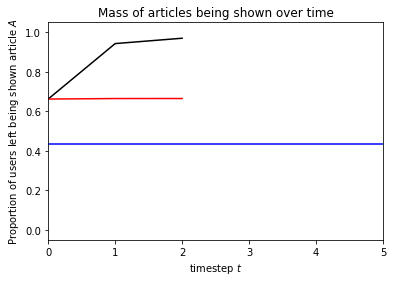

In [7]:
plt.plot(prob_article_A, color='black')
plt.plot(prob_article_A_cum, color='red')
plt.title("Mass of articles being shown over time")
plt.ylabel("Proportion of users left being shown article $A$")
plt.xlabel("timestep $t$")
plt.axhline(y=pi_a,color='blue')
plt.ylim((-0.05,1.05))
plt.xlim((0,t))
plt.show()

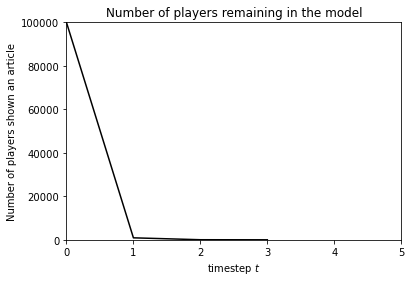

In [8]:
plt.plot(num_players_in_model, color='black')
plt.title("Number of players remaining in the model")
plt.ylabel("Number of players shown an article")
plt.xlabel("timestep $t$")
plt.xlim((0,t))
plt.ylim((0, M + 1))
plt.show()

In [6]:
'''
# out of date but afraid to erase 
plt.plot(time_data_diff, color='black')
plt.title("Mass of articles being shown over time")
plt.ylabel("learning towards article $a$ (1) and $b$ (-1)")
plt.xlabel("timestep t")
plt.ylim((-1,1))
plt.axhline(y=0,color='grey')
plt.axhline(y=np.average(time_data_diff),color='blue')
#plt.axhline(y=epsilon,color='red')
#plt.axhline(y=-1 * epsilon,color='red')
plt.show()
'''

'\n# out of date but afraid to erase \nplt.plot(time_data_diff, color=\'black\')\nplt.title("Mass of articles being shown over time")\nplt.ylabel("learning towards article $a$ (1) and $b$ (-1)")\nplt.xlabel("timestep t")\nplt.ylim((-1,1))\nplt.axhline(y=0,color=\'grey\')\nplt.axhline(y=np.average(time_data_diff),color=\'blue\')\n#plt.axhline(y=epsilon,color=\'red\')\n#plt.axhline(y=-1 * epsilon,color=\'red\')\nplt.show()\n'